In [1]:
from scipy import stats
from scipy.stats import norm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
print ("Train data shape:", train.shape)
print ("Test data shape:", test.shape)

Train data shape: (1460, 81)
Test data shape: (1459, 80)


看数值型数据的correlation

In [4]:
numeric_features = train.select_dtypes(include=[np.number])

In [5]:
numeric_features.dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1         int64
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath       int64
BsmtHalfBath       int64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars         int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice          int64
dtype: object

In [6]:
corr = numeric_features.corr()

看看房价的正相关系数大的5个，负相关系数大的5个

In [7]:
print(corr['SalePrice'].sort_values(ascending=False)[:5], '\n')

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64 



In [8]:
print(corr['SalePrice'].sort_values(ascending=False)[-5:], '\n')

YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64 



处理outliers

In [9]:
def y_x_scatter(df, y, x, lim=800000):
    tmp = pd.concat([df[y], df[x]], axis=1)
    tmp.plot.scatter(x=x, y=y, ylim=(0, lim))

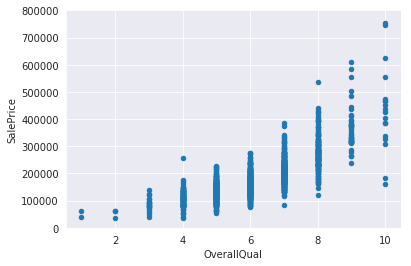

In [10]:
# 有两个异常点
y_x_scatter(train, 'SalePrice', 'OverallQual')

In [11]:
train[(train['OverallQual']==8) & (train['SalePrice'] > 500000) ]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
769,770,60,RL,47.0,53504,Pave,NaN,IR2,HLS,AllPub,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,538000


In [12]:
train[(train['OverallQual']==4) & (train['SalePrice'] > 200000) ]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
457,458,20,RL,NaN,53227,Pave,NaN,IR1,Low,AllPub,...,0,NaN,NaN,NaN,0,3,2008,WD,Normal,256000


In [13]:
train.drop([457, 769], inplace=True)

------------我是分割线---------------------------------------------------

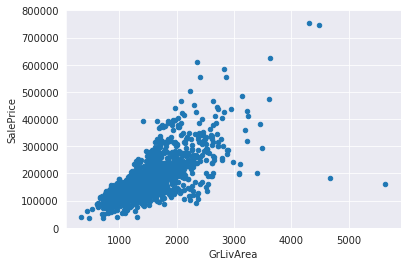

In [14]:
# 有两个异常点
y_x_scatter(train, 'SalePrice', 'GrLivArea')

In [15]:
train[train['GrLivArea']>4000]['GrLivArea'].sort_values()

691     4316
1182    4476
523     4676
1298    5642
Name: GrLivArea, dtype: int64

In [16]:
train.drop([523, 1298], inplace=True)

------------我是分割线---------------------------------------------------

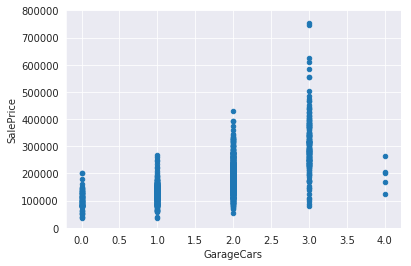

In [17]:
y_x_scatter(train, 'SalePrice', 'GarageCars')

In [18]:
train[(train['GarageCars']==3.0) & (train['SalePrice']>700000)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000


In [19]:
train.drop([691, 1182], inplace=True)

------------我是分割线---------------------------------------------------

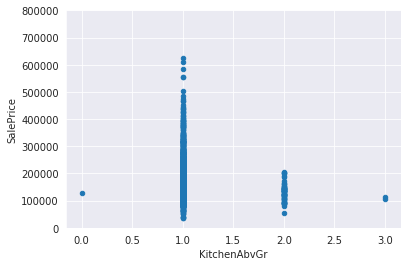

In [20]:
y_x_scatter(train, 'SalePrice', 'KitchenAbvGr')

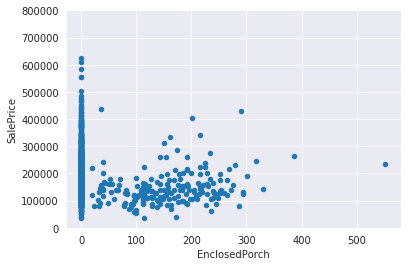

In [21]:
# 看得出来，这两个关系不大
y_x_scatter(train, 'SalePrice', 'EnclosedPorch')

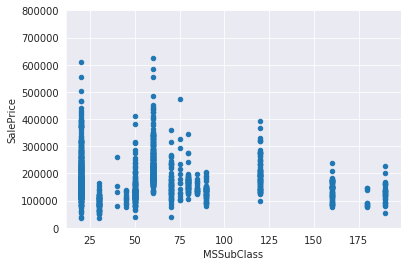

In [22]:
# 建筑类别
y_x_scatter(train, 'SalePrice', 'MSSubClass')

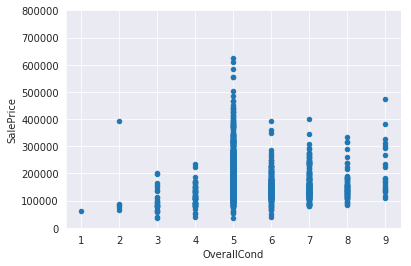

In [23]:
# 总体状况分9个等级
y_x_scatter(train, 'SalePrice', 'OverallCond')

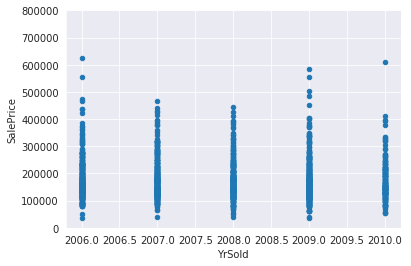

In [24]:
# 销售出去的年份，[2006, 2010]  --- 五年
y_x_scatter(train, 'SalePrice', 'YrSold')

处理missing value

In [25]:
# 看看每列缺失数据的比例，如果缺失太多说明没什么用，删除
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum() / train.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [26]:
# 以下就是在所有数据中，缺失比例前7的几个feature，超过50%的可以删除了
missing.head(7)

,Total,Percent
PoolQC,1449,0.996561
MiscFeature,1400,0.962861
Alley,1363,0.937414
Fence,1174,0.807428
FireplaceQu,690,0.474553
LotFrontage,258,0.177442
GarageCond,81,0.055708


In [27]:
train = train.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'])

In [28]:
print(train.shape)

(1454, 76)


In [29]:
# 数值类型，空的直接线性插值
train = train.interpolate()

In [30]:
# 剩下来的这些都是枚举值类型的数据
train.isnull().sum().sort_values(ascending=False)[:12]

GarageQual      81
GarageType      81
GarageFinish    81
GarageCond      81
BsmtExposure    38
BsmtFinType2    38
BsmtFinType1    37
BsmtCond        37
BsmtQual        37
MasVnrType       8
Electrical       1
RoofStyle        0
dtype: int64

构造新的特征

In [31]:
# 月份其实是枚举类型
mon_map = {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun", 
           7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
train['MoSold'] = train['MoSold'].map(mon_map)

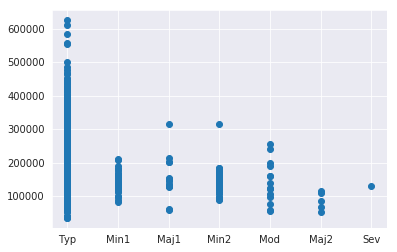

In [32]:
# 这个存在样本不均衡的问题
plt.scatter(train['Functional'], train['SalePrice'])

In [33]:
train['Functional'].value_counts()

Typ     1356
Min2      34
Min1      30
Maj1      14
Mod       14
Maj2       5
Sev        1
Name: Functional, dtype: int64

In [34]:
train.shape

(1454, 76)

In [35]:
# 39个枚举型特征
train.dtypes.sort_values(ascending=False)[:39]

Condition2       object
Condition1       object
ExterQual        object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Electrical       object
CentralAir       object
HeatingQC        object
Heating          object
SaleCondition    object
Exterior2nd      object
MasVnrType       object
BsmtFinType2     object
BsmtFinType1     object
BsmtExposure     object
BsmtCond         object
BsmtQual         object
Foundation       object
KitchenQual      object
ExterCond        object
Functional       object
GarageQual       object
SaleType         object
MoSold           object
MSZoning         object
Street           object
LotShape         object
LandContour      object
Utilities        object
Neighborhood     object
GarageCond       object
PavedDrive       object
LotConfig        object
LandSlope        object
GarageFinish     object
GarageType       object
dtype: object

街道street转为ont-hot

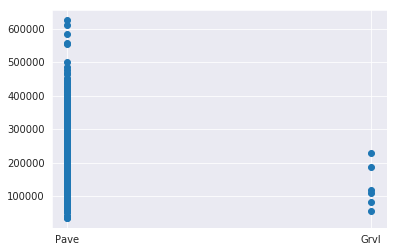

In [36]:
plt.scatter(train['Street'], train['SalePrice'])

In [37]:
train = pd.get_dummies(train, columns=['Street'])

In [38]:
train.shape

(1454, 77)

保存预处理过的train数据

In [39]:
train.to_csv('train_filter.csv', index=False)

模型训练，预测

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [41]:
# 将SalePrice取log，转为正太
y = np.log(train.SalePrice)

data = train.select_dtypes(include=[np.number])

x = data.drop(['SalePrice', 'Id'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size=0.3)

In [42]:
lr = LinearRegression()

In [43]:
model = lr.fit(x_train, y_train)

In [44]:
predictions = model.predict(x_test)

In [45]:
mean_squared_error(y_test, predictions)

0.018217409974217474

预测

In [46]:
test = test.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'])
test['MoSold'] = test['MoSold'].map(mon_map)
test = pd.get_dummies(test, columns=['Street'])

In [47]:
feats = test.select_dtypes(include=[np.number]).drop(['Id'], axis=1).interpolate()

In [48]:
predictions = model.predict(feats)
final_predictions = np.exp(predictions)

写入CSV

In [49]:
dic = {'Id': [1461 + i for i in range(1459)], 'SalePrice': final_predictions}

In [50]:
df = pd.DataFrame(dic)

In [51]:
df.to_csv('model_predict.csv', index=False)